# 802.11a/g 解调

In [2]:
import numpy as np
from numpy import real, imag, angle
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import ifft, fft, fftshift

%matplotlib widget

In [3]:
FS = 20e6
LTS_F = np.load("lts.npy")
LTS_T = ifft(fftshift(LTS_F))
LTS_LEN = 64
STS_LEN = 16
CP_LEN = 16
N = 64
DATA_IND = np.hstack((np.arange(6, 11), np.arange(12, 25), np.arange(26, 32), np.arange(33, 39), np.arange(40, 53), np.arange(54, 59)))
PILOT_IND = np.array([11, 25, 39, 53])
PILOT_SCRAMBLE = np.load("pilot.npy")

def power_detector(sig, window_len):
    sig = np.abs(sig)
    a = np.convolve(sig[:-window_len], np.ones(window_len), "same")
    b = np.convolve(sig[window_len:], np.ones(window_len), "same")
    return 10 * np.log10(b / a)

class WIFIDecoder:
    def __init__(self, lts_f, sts_len, cp_len, fs):
        self.lts_f = lts_f
        self.lts_t = ifft(fftshift(lts_f))
        self.lts_len = len(lts_f)
        self.sts_len = sts_len
        self.cp_len = cp_len
        self.fs = fs

    def find_packet_edge(self, sig, threshoud):
        sts_len = self.sts_len
        corr = sig[:-sts_len] * np.conj(sig[sts_len:])
        power = sig[sts_len:] * np.conj(sig[sts_len:])
        corr_sum = np.convolve(corr, np.ones(sts_len), "same")
        power_sum = np.convolve(power, np.ones(sts_len), "same")
        decision = corr > power
        decision = corr_sum > power_sum * threshoud
        peaks = signal.find_peaks(decision, width=128)
        if len(peaks) > 0:
            return peaks[1]["left_bases"][0] - sts_len
        else:
            return 0

    def fine_time_sync(self, sig, threshoud):
        lts_t = self.lts_t
        lts_len = self.lts_len
        cp_len = self.cp_len
        corr = signal.correlate(sig, lts_t, "same")
        lts_pos, _ = signal.find_peaks(np.abs(corr), height=threshoud)
        if len(lts_pos) < 1:
            return 0
        return lts_pos[0] - 32

    def coarse_cfo_estimate(self, sig):
        sig = sig[16:]
        sts_len = self.sts_len
        sts_seq_1 = sig[1 * sts_len : 8 * sts_len]
        sts_seq_2 = sig[2 * sts_len : 9 * sts_len]
        cfo_est_sts = angle(np.sum(sts_seq_2 * np.conj(sts_seq_1)))
        cfo_est_sts = -cfo_est_sts / (2 * np.pi * sts_len / self.fs)
        return cfo_est_sts

    def fine_cfo_estimate(self, sig):
        lts_len = self.lts_len
        lts1 = sig[0 * lts_len: 1 * lts_len]
        lts2 = sig[1 * lts_len: 2 * lts_len]
        cfo_est_lts = angle(np.sum(lts2 * np.conj(lts1)));
        cfo_est_lts = -cfo_est_lts / (2 * np.pi * lts_len / self.fs);
        return cfo_est_lts

    def freq_compensation(self, sig, freq_offset):
        return sig * np.exp(
            1j * 2 * np.pi * freq_offset * (np.arange(len(sig)) / self.fs)
        )

    def channel_estimate(self, sig):
        lts_len = self.lts_len
        lts_f = fftshift(self.lts_f)
        lts1 = sig[0 * lts_len: 1 * lts_len]
        lts2 = sig[1 * lts_len: 2 * lts_len]
        lts1_f = fft(lts1)
        lts2_f = fft(lts2)
        h1 = lts_f / lts1_f
        h2 = lts_f / lts2_f
        return (h1 + h2) / 2
    
    def pilot_phase_estimate(self, pilot_symbols):
        pilot_symbols_true = np.repeat(PILOT_SCRAMBLE, 4).reshape(-1, 4) * [1, 1, 1, -1]
        pilot_symbols_true = np.tile(pilot_symbols_true, (pilot_symbols.shape[0] // pilot_symbols_true.shape[0] + 1, 1))
        pilot_symbols_true = pilot_symbols_true[:pilot_symbols.shape[0],:]
        phases = angle(np.average((np.conj(pilot_symbols_true) * pilot_symbols), axis=-1))
        phases = np.exp(-1j * phases)[:,None]
        return phases

In [6]:
sig = np.memmap("iq.dat", dtype=np.complex64)
power_trigger = power_detector(sig, window_len=500)
frame_start_pos, _ = signal.find_peaks(power_trigger > 8)

def get_frame(index):
    return sig[frame_start_pos[index]:frame_start_pos[index]+42000]

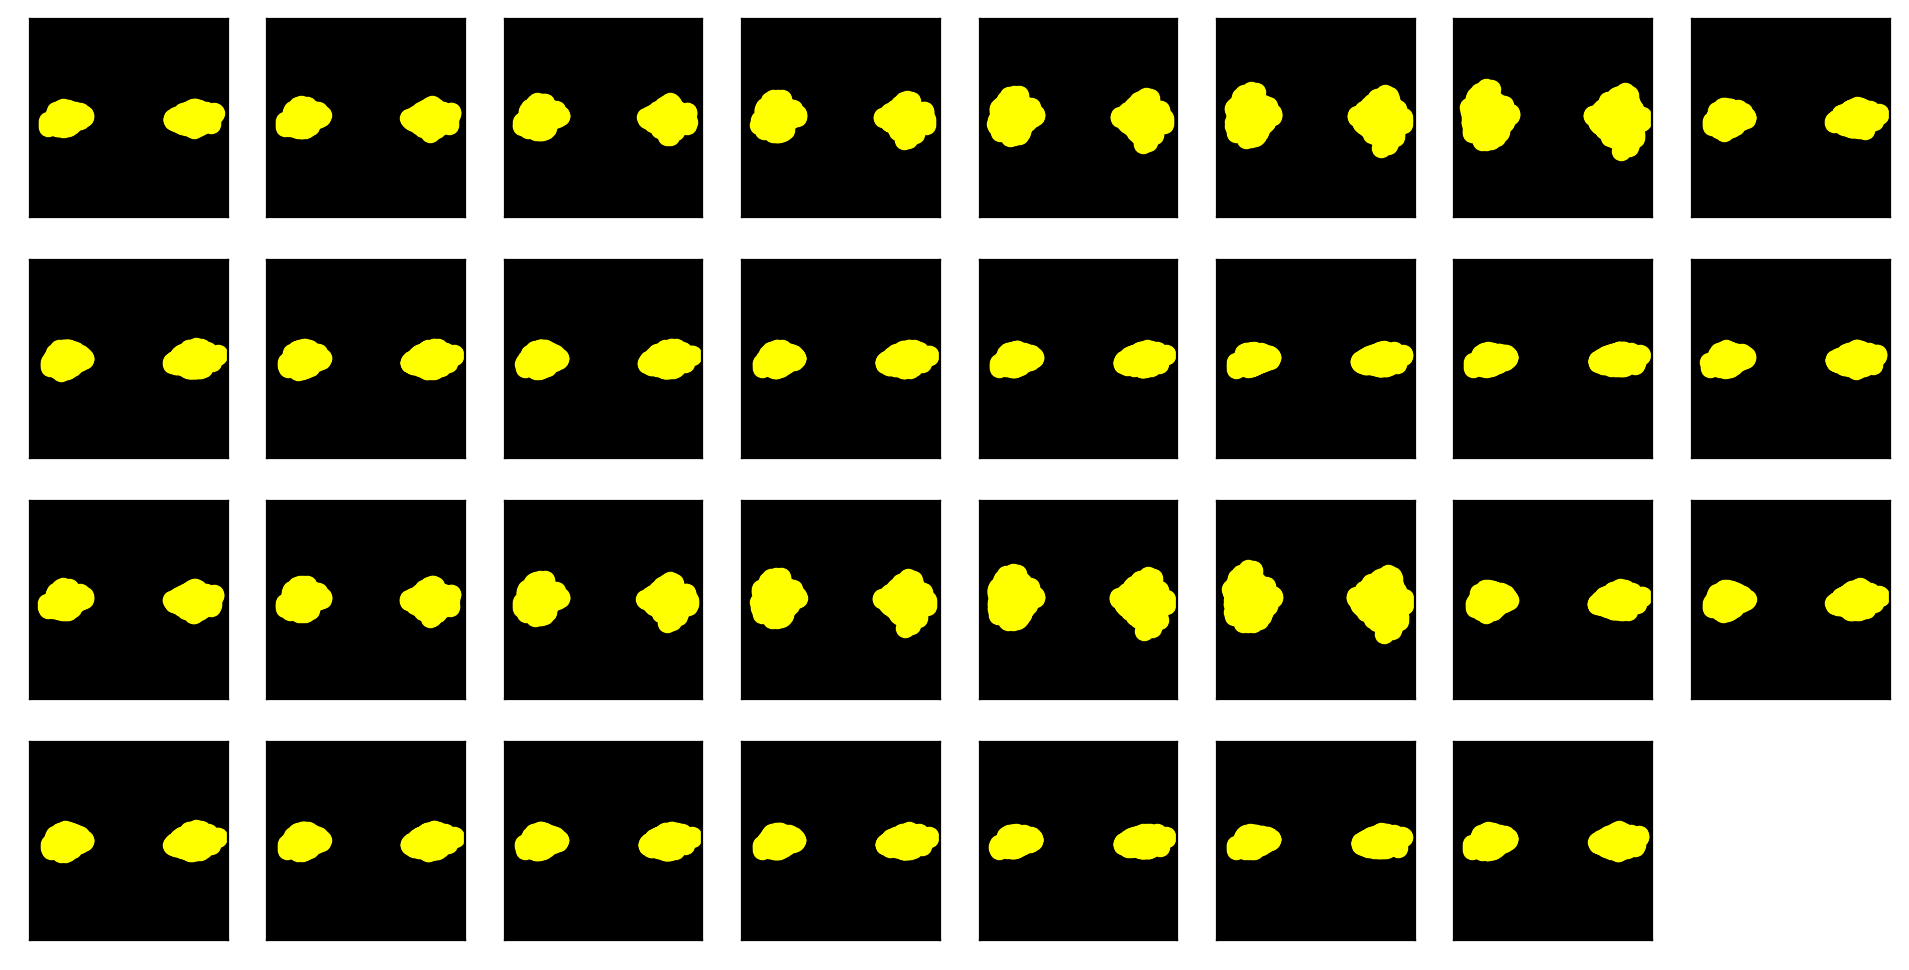

In [7]:

def decode_frame(frame, wifi_decoder):
    pos = wifi_decoder.find_packet_edge(frame, 0.9)
    frame = frame[pos:]

    # 粗略载波频率偏移估计
    coarse_cfo = wifi_decoder.coarse_cfo_estimate(frame)
    frame = wifi_decoder.freq_compensation(frame, coarse_cfo)
    # 精细时间对齐(LTS)
    pos = wifi_decoder.fine_time_sync(frame, 0.2)
    frame = frame[pos:]

    # 精细载波频率偏移估计
    fine_cfo = wifi_decoder.fine_cfo_estimate(frame)
    frame = wifi_decoder.freq_compensation(frame, fine_cfo)
    # 信道参数估计
    channel_estimate = wifi_decoder.channel_estimate(frame)
    frame = frame[2 * LTS_LEN:]
    # 解调500个符号
    frame = frame[:(N + CP_LEN) * 500]
    # 变换成[500(行) * 符号长度(列)]的矩阵
    frame = frame.reshape(500, N + CP_LEN)
    # 去除CP
    frame = frame[:,CP_LEN:]
    # 时域转频域
    frame = fft(frame, axis=-1)
    # 使用信道参数纠正
    frame = frame * channel_estimate
    frame = fftshift(frame, axes=-1)


    # 数据信道
    data_symbols = frame[:,DATA_IND]
    # 导频信道
    pilot_symbols = frame[:,PILOT_IND]

    # 通过导频相位补偿
    phases = wifi_decoder.pilot_phase_estimate(pilot_symbols)
    data_symbols *= phases
    return data_symbols


wifi_decoder = WIFIDecoder(lts_f=LTS_F, sts_len=STS_LEN, cp_len=CP_LEN, fs=FS)

%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(4, 8)
fig.set_size_inches(12, 6)

ax = ax.reshape(-1)
ax[-1].remove()

for i in range(31):
    data_symbols = decode_frame(get_frame(i), wifi_decoder)
    # 绘制星座图
    data = data_symbols.reshape(-1)
    axes = ax[i]
    axes.grid(True)
    axes.set_aspect(1)
    axes.set_facecolor("black")
    axes.set_xlim(-1.5, 1.5)
    axes.set_ylim(-1.5, 1.5)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.scatter(np.real(data), np.imag(data), color="yellow")
plt.show()